## Import Library

In [ ]:
!pip install tensorflowjs

In [ ]:
from google.colab import files
files.upload()
import os,shutil
import io
import seaborn as sns
import random
from random import sample
import matplotlib.pyplot as plt
import pathlib
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
import cv2
from PIL import Image
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array , load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer,Conv2D, SeparableConv2D, MaxPooling2D,MaxPool2D, Dense,Flatten, Dropout,BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint,Callback, EarlyStopping
import warnings
from skimage import io
from collections import Counter
warnings.simplefilter(action='ignore', category=FutureWarning)
from google.colab import files

Saving kaggle.json to kaggle.json


## Gathering Data

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d juanzi/basetrash2

Dataset URL: https://www.kaggle.com/datasets/juanzi/basetrash2
License(s): unknown
 96% 1.16G/1.20G [00:07<00:00, 173MB/s]
100% 1.20G/1.20G [00:07<00:00, 179MB/s]


In [ ]:
!unzip /content/basetrash2.zip

Streaming output truncated to the last 5000 lines.
  inflating: Dataset_Fix_3/Karton/cardboard_504.jpg  
  inflating: Dataset_Fix_3/Karton/cardboard_506.jpg  
  inflating: Dataset_Fix_3/Karton/cardboard_508.jpg  
  inflating: Dataset_Fix_3/Karton/cardboard_509.jpg  
  inflating: Dataset_Fix_3/Karton/cardboard_514.jpg  
  inflating: Dataset_Fix_3/Karton/cardboard_516.jpg  
  inflating: Dataset_Fix_3/Karton/cardboard_517.jpg  
  inflating: Dataset_Fix_3/Karton/cardboard_521.jpg  
  inflating: Dataset_Fix_3/Karton/cardboard_523.jpg  
  inflating: Dataset_Fix_3/Karton/cardboard_53.jpg  
  inflating: Dataset_Fix_3/Karton/cardboard_532.jpg  
  inflating: Dataset_Fix_3/Karton/cardboard_533.jpg  
  inflating: Dataset_Fix_3/Karton/cardboard_535.jpg  
  inflating: Dataset_Fix_3/Karton/cardboard_541.jpg  
  inflating: Dataset_Fix_3/Karton/cardboard_55.jpg  
  inflating: Dataset_Fix_3/Karton/cardboard_553.jpg  
  inflating: Dataset_Fix_3/Karton/cardboard_557.jpg  
  inflating: Dataset_Fix_3/Karton

## Alur 1: Train Model tanpa Augmentasi

In [ ]:
os.makedirs('/content/Trash/dataset')

In [ ]:
old_path="/content/Dataset_Fix_3"
trash_path="/content/Trash/dataset"

In [ ]:
for category in os.listdir(old_path):
  category_dir=os.path.join(old_path, category)
  if os.path.isdir(category_dir):
    if os.path.isdir(category_dir):
      shutil.copytree(category_dir, os.path.join(trash_path, category), dirs_exist_ok=True)


### Visualisasi Gambar

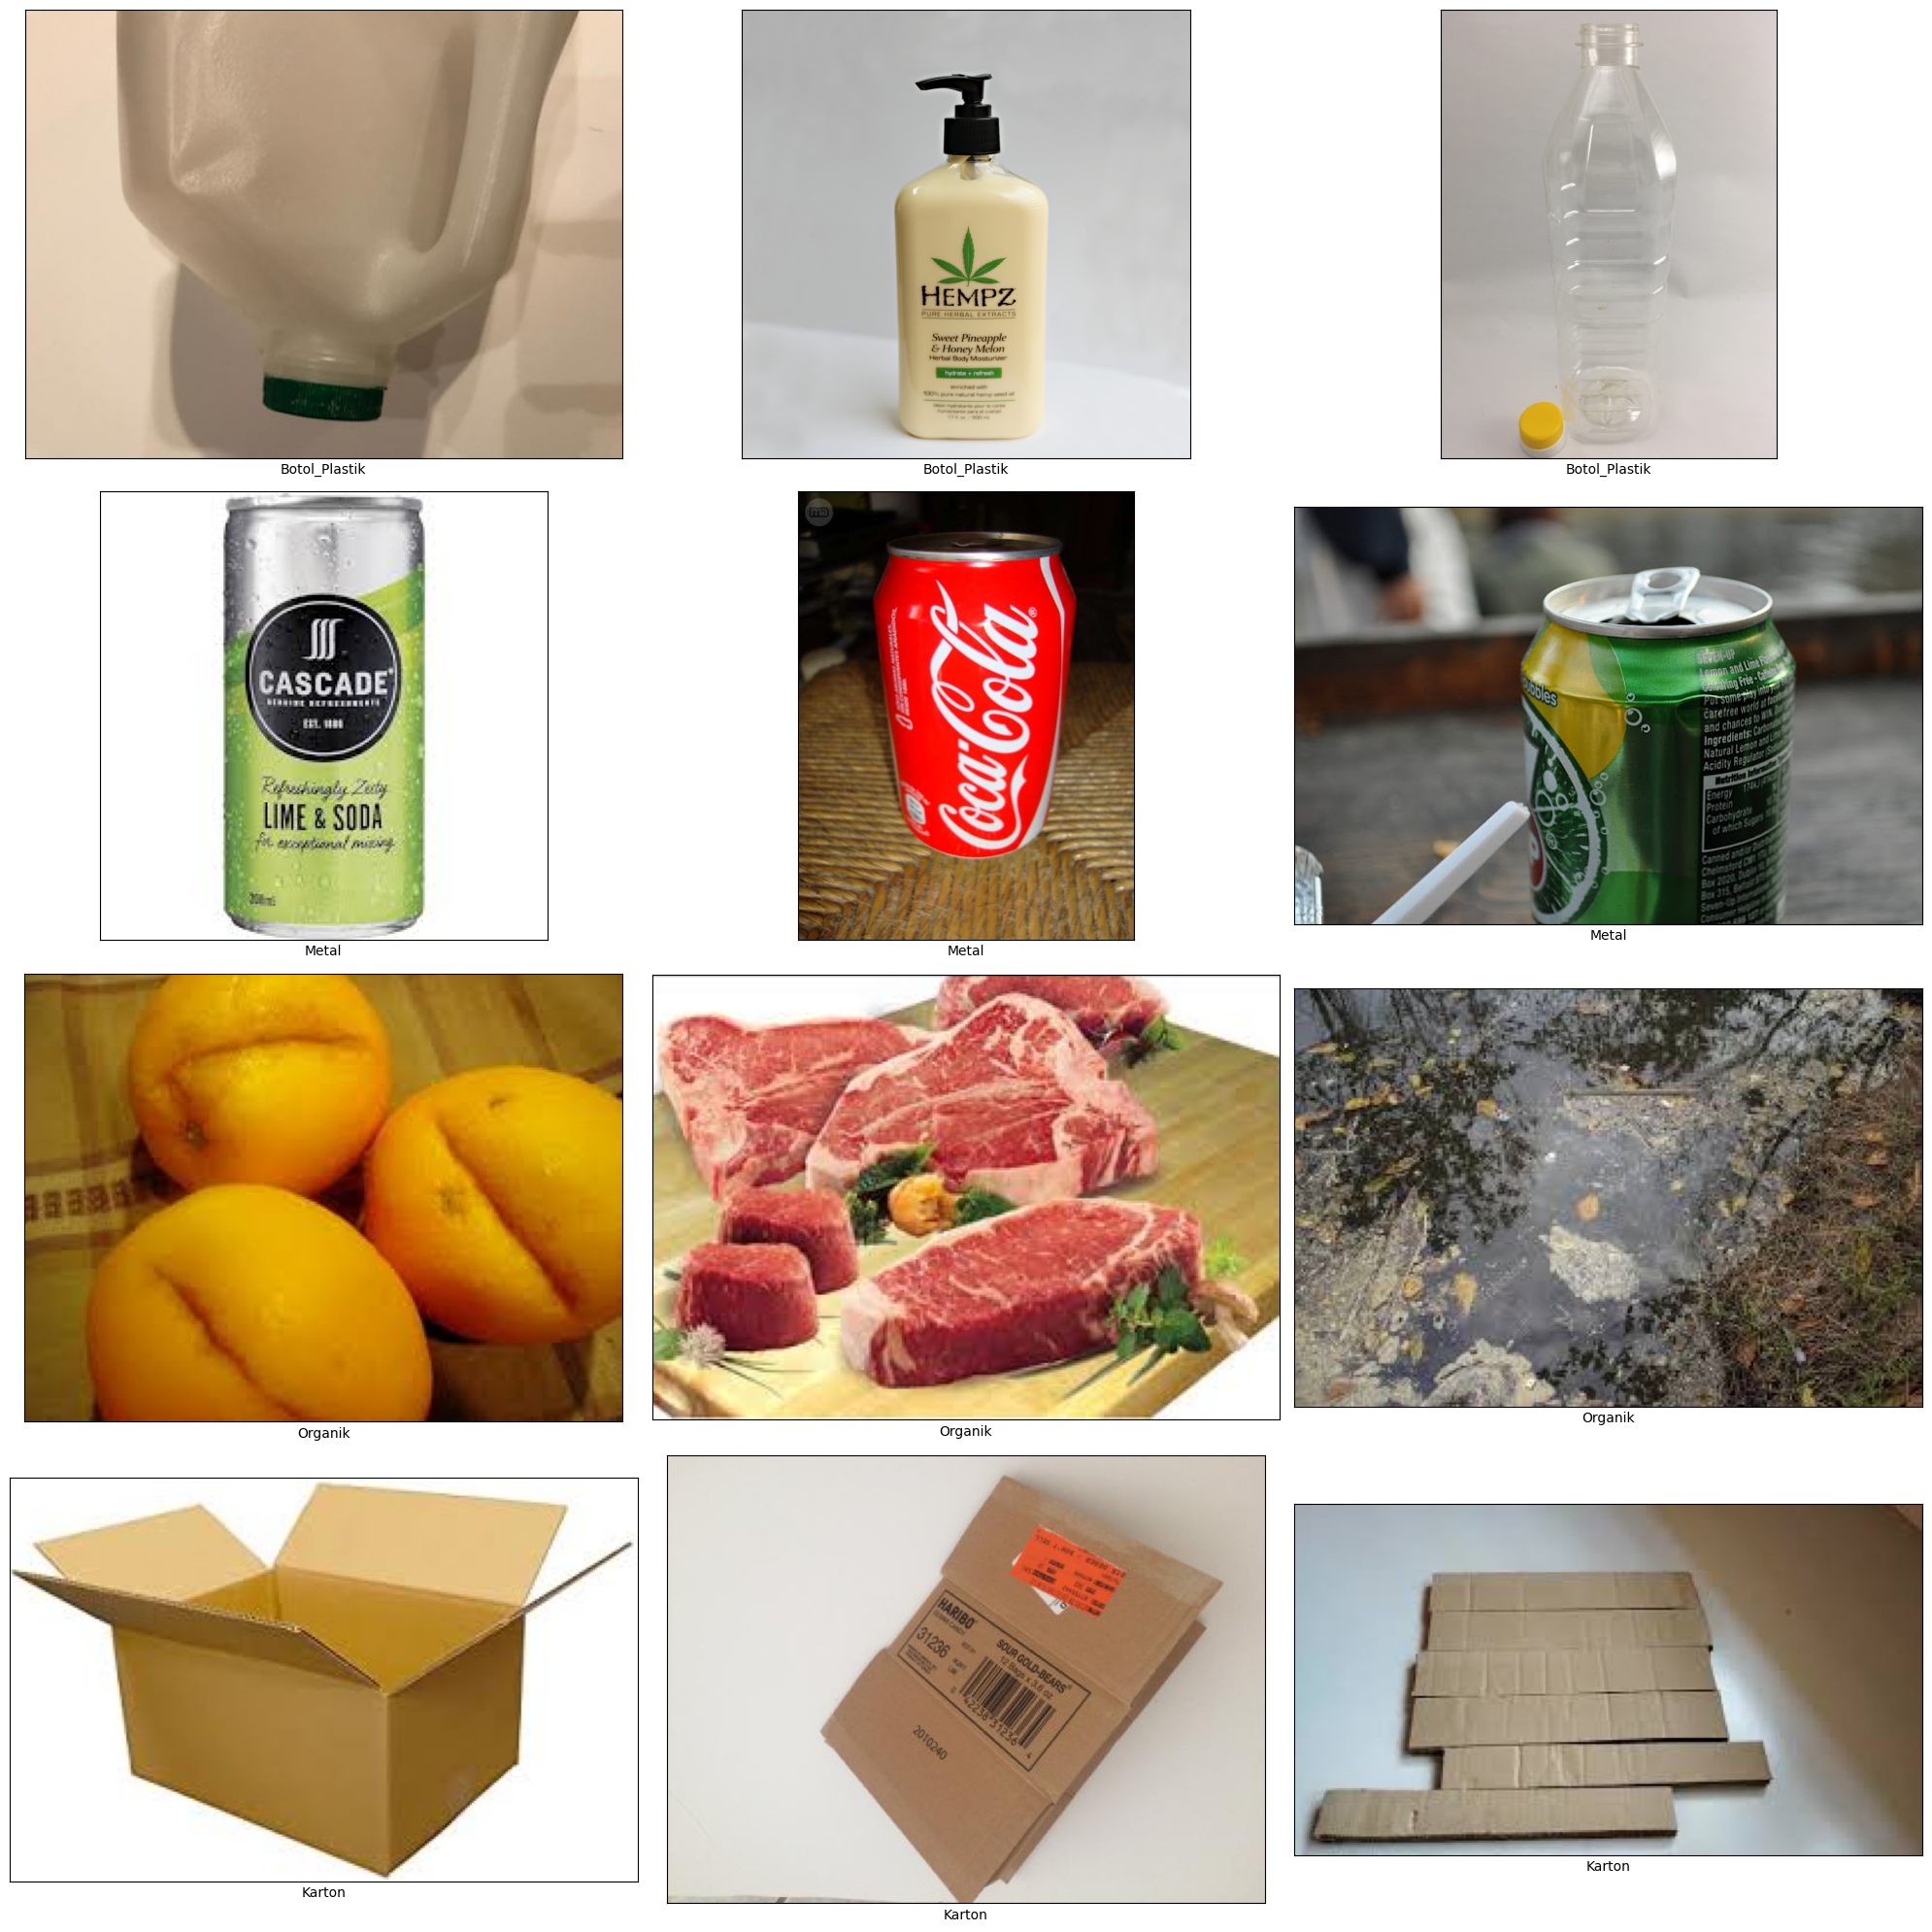

In [ ]:
trash_cat={}
path="/content/Trash"
path_sub=os.path.join(path, "dataset")

for i in os.listdir(path_sub):
  trash_cat[i]=os.listdir(os.path.join(path_sub, i))

path_sub="/content/Trash/dataset"

fig,axs=plt.subplots(len(trash_cat.keys()), 3, figsize=(20,20))
for i, class_name in enumerate(os.listdir(path_sub)):
  images=np.random.choice(trash_cat[class_name], 3, replace=False)
  for j, image_name in enumerate(images):
    img_path=os.path.join(path_sub, class_name, image_name)
    img=Image.open(img_path)
    axs[i,j].imshow(img)
    axs[i,j].set(xlabel=class_name, xticks=[], yticks=[])

fig.tight_layout()

### Menghitung Jumlah gambar

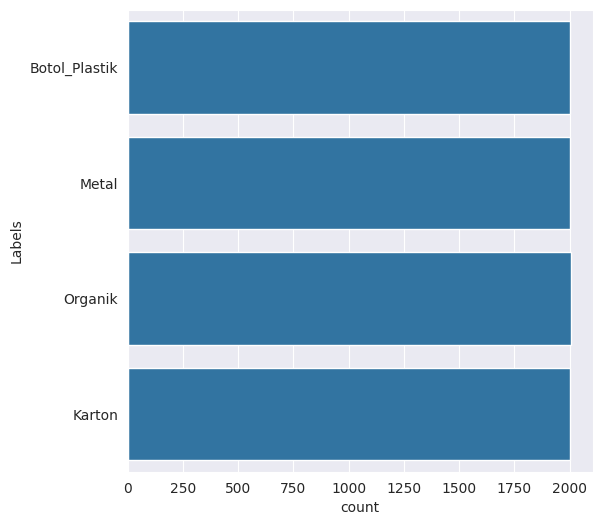

In [ ]:
trash_cat="/content/Trash/dataset"
file_name=[]
labels=[]
full_path=[]
for path ,subdirs, files in os.walk(trash_cat):
  for name in files:
    full_path.append(os.path.join(path, name))
    labels.append(path.split('/') [-1])
    file_name.append(name)

distribution_data=pd.DataFrame({"path":full_path, 'file_name':file_name, 'Labels':labels})

Label=distribution_data['Labels']
plt.figure(figsize=(6,6))
sns.set_style('darkgrid')
plt.data=sns.countplot(Label)

### Menghitung Jumlah dan tipe gambar

In [ ]:
def count_img_type(directory):
  image_ext=['.jpg','.jpeg','.png','.bmp','.tiff','.gif']
  ext_counter=Counter()

  for root, dirs,files in os.walk(directory):
    for file in files:
      ext=os.path.splitext(file)[1].lower()
      if ext in image_ext:
        ext_counter[ext] +=1

  print("\n Statistik tipe gambar")
  total=sum(ext_counter.values())
  for ext, count in ext_counter.items():
    print(f"{ext}: {count} file")
count_img_type('/content/Trash/dataset')


 Statistik tipe gambar
.jpg: 7571 file
.jpeg: 63 file
.png: 368 file
.gif: 2 file


### Menghapus file tope Gif

In [ ]:
def del_image(directory):
  deleted_count=0
  for root, dirs, files in os.walk(directory):
    for file in files:
      if file.lower().endswith('.gif'):
        file_path=os.path.join(root, file)
        try:
          os.remove(file_path)
          deleted_count +=1
          print(f"Deleted: {file_path}")
        except Exception as e:
          print("error deleting")
  print(f"\nTotal .gif  files deleted:{deleted_count}")

del_image('/content/Trash/dataset')

Deleted: /content/Trash/dataset/Botol_Plastik/bouteille_plastique_25.gif
Deleted: /content/Trash/dataset/Botol_Plastik/bouteille_plastique_24.gif

Total .gif  files deleted:2


### Melakukan resize gambar

In [ ]:
def resize_image(directory, target_size=(224,224)):
  for root, dirs, files in os.walk(directory):
    for file in files:
      if file.lower().endswith(('.jpg','.jpeg','.png')):
        img_path=os.path.join(root, file)
        img=Image.open(img_path)
        if img.mode !="RGB":
          img=img.convert('RGB')
        img=img.resize(target_size, Image.Resampling.LANCZOS)
        img.save(img_path)

resize_image('/content/Trash/dataset', target_size=(224,224))

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [ ]:
my_path="/content/Trash/dataset"

file_name=[]
labels=[]
full_path=[]

for path, subdirs, files in os.walk(my_path):
  for name in files:
    full_path.append(os.path.join(path, name))
    labels.append(path.split('/')[-1])
    file_name.append(name)


df=pd.DataFrame({"path":full_path, "file_name":file_name, "labels":labels})
df.groupby((['labels'])).size()

labels
Botol_Plastik    1998
Karton           2000
Metal            2000
Organik          2005
dtype: int64

In [ ]:
X=df['path']
y=df['labels']
X_train, X_test, y_train,y_test=train_test_split(X,y, test_size=0.2, random_state=42)

In [ ]:
df_tr=pd.DataFrame({'path':X_train, 'labels':y_train, 'set':'train'})
df_ts=pd.DataFrame({'path':X_test, 'labels':y_test, 'set':'test'})

In [ ]:
df_all=pd.concat([df_tr,df_ts],ignore_index=True)
print("============================================\n")
print(df_all.groupby(['set','labels']).size(),'\n')
print("===========================================\n")

print(df_all.sample(5))

datasource_path="/content/Trash/dataset"
dataset_path="/content/Dataset/Final1"
os.makedirs(dataset_path, exist_ok=True)


set    labels       
test   Botol_Plastik     420
       Karton            391
       Metal             386
       Organik           404
train  Botol_Plastik    1578
       Karton           1609
       Metal            1614
       Organik          1601
dtype: int64 


                                                   path         labels    set
7401  /content/Trash/dataset/Organik/biological_375.jpg        Organik   test
6355  /content/Trash/dataset/Botol_Plastik/plastic_1...  Botol_Plastik  train
1674     /content/Trash/dataset/Karton/cardboard160.jpg         Karton  train
6150            /content/Trash/dataset/Organik/O_44.jpg        Organik  train
1647        /content/Trash/dataset/Metal/Metal_1295.jpg          Metal  train


In [ ]:
for index, row in tq(df_all.iterrows()):
  file_path=row['path']
  if os.path.exists(file_path) ==False:
    file_path=os.path.join(datasource_path, row['labels'], row['image'],split('.')[0])

  if os.path.exists(os.path.join(dataset_path,row['set'], row['labels'])) ==False:
    os.makedirs(os.path.join(dataset_path, row['set'], row['labels'])) ==True

  destination_file_name=file_path.split('/')[-1]

  file_dest=os.path.join(dataset_path, row['set'], row['labels'], destination_file_name)

  if os.path.exists(file_dest) ==False:
    shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

In [ ]:
TRAIN_DIR="/content/Dataset/Final1/train"
TEST_DIR="/content/Dataset/Final1/test"

train_botp= os.path.join(TRAIN_DIR +'/Botol_Plastik')
train_kar=os.path.join(TRAIN_DIR +'/Karton')
train_met=os.path.join(TRAIN_DIR +'/Metal')
train_org=os.path.join(TRAIN_DIR +'/Organik')

test_botp= os.path.join(TEST_DIR +'/Botol_Plastik')
test_kar=os.path.join(TEST_DIR +'/Karton')
test_met=os.path.join(TEST_DIR +'/Metal')
test_org=os.path.join(TEST_DIR +'/Organik')


In [ ]:
datagen=ImageDataGenerator(rescale=1/225., validation_split=0.2)
test_datagen=ImageDataGenerator(rescale=1. /255)
train_generator=datagen.flow_from_directory(TRAIN_DIR,
                                            batch_size=32,
                                            target_size=(150,150),
                                            class_mode='categorical',
                                            subset='training',
                                            shuffle=True
                                            )
validation_generator=datagen.flow_from_directory(TRAIN_DIR,
                                                 batch_size=32,
                                                 target_size=(150,150),
                                                 class_mode='categorical',
                                                 subset='validation',
                                                 shuffle=False)

testing_generator=test_datagen.flow_from_directory(TEST_DIR,
                                                   batch_size=1,
                                                   target_size=(150,150),
                                                   class_mode='categorical',
                                                   shuffle=False)

Found 5123 images belonging to 4 classes.
Found 1278 images belonging to 4 classes.
Found 1601 images belonging to 4 classes.


Arsitektur Model 1

In [ ]:
model=Sequential()

model.add(Conv2D(32,(3,3), padding='same',activation='relu', input_shape=(150,150,3)))
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(64,(5,5), padding='same',activation='relu'))
model.add(Conv2D(64,(5,5),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (7,7), padding='same', activation='relu'))
model.add(Conv2D(128, (7,7), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.3))


model.add(Conv2D(128, (11,11), padding='same',activation='relu'))
model.add(Conv2D(128, (11,11),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(4,activation='softmax'))

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 148, 148, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 74, 74, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 70, 70, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 70, 70, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 35, 35, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 35, 35, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 35, 35, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 29, 29, 128)    │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 29, 29, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 14, 14, 128)    │     1,982,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 128)      │     1,982,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             

 Total params: 5,499,684 (20.98 MB)

 Trainable params: 5,498,980 (20.98 MB)

 Non-trainable params: 704 (2.75 KB)

In [ ]:
class_names = [
    'Botol_Plastik', 'Karton',
    'Metal', 'Organik'
]

# Hitung jumlah gambar untuk tiap kelas
class_counts = {}
for class_name in class_names:
    class_path = os.path.join(TRAIN_DIR, class_name)
    class_counts[class_name] = len(os.listdir(class_path))

# Total semua gambar
total_images = sum(class_counts.values())

# Hitung class weights
class_weights = {}
for idx, class_name in enumerate(class_names):
    count = class_counts[class_name]
    class_weights[idx] = (1 / count) * (total_images / len(class_names))



In [ ]:
class CustomCallback(Callback):
  def on_epoch_end(self, epoch,logs=None):
    logs=logs or {}
    val_acc=logs.get('val_accuracy')
    val_loss=logs.get('val_loss')

    if val_acc is not None and val_loss is not None:
      if val_acc >=0.85 and val_loss <=0.55:
        print(f"\nTraining Model Stopped: val_accuracy={val_acc:.2f}, val loss:{val_loss:.2f}")
        self.model.stop_training=True

In [ ]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='categorical_crossentropy',metrics =['accuracy'])

In [ ]:
history=model.fit(
    train_generator,
    epochs=60,
    batch_size=32,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[CustomCallback()]
)

Epoch 1/60


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


161/161 ━━━━━━━━━━━━━━━━━━━━ 52s 198ms/step - accuracy: 0.3658 - loss: 1.6024 - val_accuracy: 0.4476 - val_loss: 2.4631
Epoch 2/60
161/161 ━━━━━━━━━━━━━━━━━━━━ 52s 113ms/step - accuracy: 0.5893 - loss: 1.0601 - val_accuracy: 0.4601 - val_loss: 1.3592
Epoch 3/60
161/161 ━━━━━━━━━━━━━━━━━━━━ 17s 107ms/step - accuracy: 0.6339 - loss: 0.9234 - val_accuracy: 0.3928 - val_loss: 2.7433
Epoch 4/60
161/161 ━━━━━━━━━━━━━━━━━━━━ 18s 109ms/step - accuracy: 0.6906 - loss: 0.8495 - val_accuracy: 0.7019 - val_loss: 0.8589
Epoch 5/60
161/161 ━━━━━━━━━━━━━━━━━━━━ 18s 109ms/step - accuracy: 0.6933 - loss: 0.8254 - val_accuracy: 0.6463 - val_loss: 0.8778
Epoch 6/60
161/161 ━━━━━━━━━━━━━━━━━━━━ 17s 108ms/step - accuracy: 0.7232 - loss: 0.7695 - val_accuracy: 0.3372 - val_loss: 1.6777
Epoch 7/60
161/161 ━━━━━━━━━━━━━━━━━━━━ 17s 107ms/step - accuracy: 0.7417 - loss: 0.6955 - val_accuracy: 0.7645 - val_loss: 0.7207
Epoch 8/60
161/161 ━━━━━━━━━━━━━━━━━━━━ 19s 116ms/step - accuracy: 0.7657 - loss: 0.6609 - val

### Melakukan testing pada data train

In [ ]:
loss, accuracy=model.evaluate(train_generator)
print(f"Loss:{loss:.4f}")
print(f"Akurasi:{accuracy:.4f}")


161/161 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9672 - loss: 0.0990
Loss:0.0853
Akurasi:0.9742


### Melakukan testing pada data testing

In [ ]:
loss, accuracy=model.evaluate(testing_generator)
print(f"Loss:{loss:.4f}")
print(f"Akurasi:{accuracy:.4f}")


1601/1601 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8978 - loss: 0.4158
Loss:0.4217
Akurasi:0.8994


### Grafik akurasi dan loss selama training

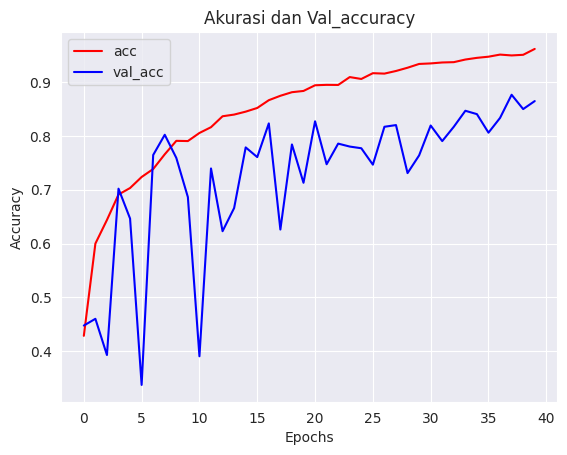

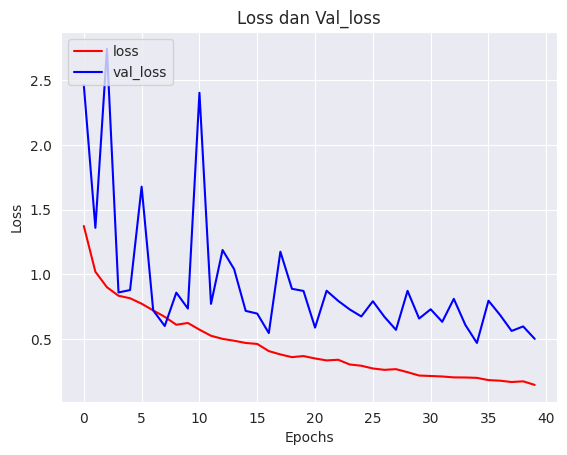

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc,'b')
plt.title('Akurasi dan Val_accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['acc', 'val_acc'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Loss dan Val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

### Confusion Matrix pada Model 1

1601/1601 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step


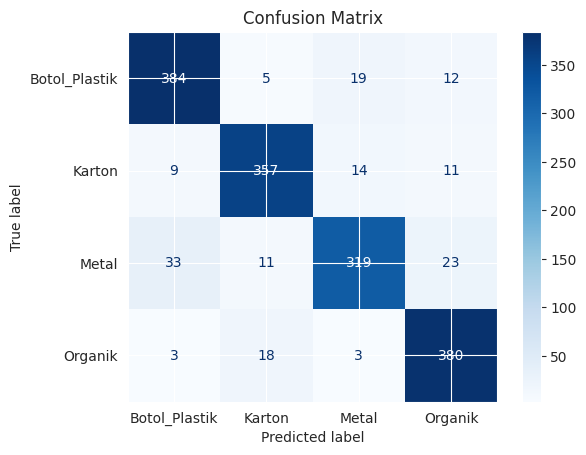

Classification Report 
                precision    recall  f1-score   support

Botol_Plastik       0.90      0.91      0.90       420
       Karton       0.91      0.91      0.91       391
        Metal       0.90      0.83      0.86       386
      Organik       0.89      0.94      0.92       404

     accuracy                           0.90      1601
    macro avg       0.90      0.90      0.90      1601
 weighted avg       0.90      0.90      0.90      1601



In [ ]:
Y_pred=model.predict(testing_generator)

y_pred=np.argmax(Y_pred, axis=1)
y_true=testing_generator.classes
class_names=list(testing_generator.class_indices.keys())

Confusion=confusion_matrix(y_true, y_pred)
display=ConfusionMatrixDisplay(confusion_matrix=Confusion, display_labels=class_names)
display.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

report=classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report \n", report )

## Alur model tahap 2: Tanpa Augmentasi

In [ ]:
old_path="/content/Trash/dataset"
new_path="/content/Trash1/dataset"

In [ ]:
for category in os.listdir(old_path):
  category_dir=os.path.join(old_path, category)
  if os.path.isdir(category_dir):
    shutil.copytree(category_dir, os.path.join(new_path, category), dirs_exist_ok=True)

### Augmentasi gambar

In [ ]:
def anticlockwise_rotation(img):
  sudut=random.randint(0,180)
  return rotate(img,sudut)

def clockwise_rotation(img):
  sudut=random.randint(0,180)
  return rotate(img, -sudut)

def flip_up_down(img):
    img=cv2.resize(img, (224,224))
    return np.flipud(img)

def add_brightness(img):
  img=adjust_gamma(img, gamma=0.5, gain=1)
  return img

def blur_imag(img):
  return cv2.GaussianBlur(img,(9,9),0)

def sheared_img(img):
  transform=AffineTransform(shear=0.2)
  shear_image=warp(img, transform,mode="wrap")
  return shear_image

def warp_shift(img):
  transform=AffineTransform(translation=(0,40))
  warp_image=warp(img, transform, mode="wrap")
  return warp_image

In [ ]:
transformations={
    'rotate anticlockwise':anticlockwise_rotation,
    'rotate clockwise':clockwise_rotation,
    'warp shift': warp_shift,
    'brightness':add_brightness,
    'blur image':blur_imag,
    'flip up down':flip_up_down,
    'shear image':sheared_img
}

In [ ]:
categories=['Botol_Plastik','Karton','Metal','Organik']
base_path="/content/Trash1/dataset"
images_to_generate=3000

for category in categories:
  image_path=os.path.join(base_path, category)
  augmented_path=image_path

  images=[os.path.join(image_path,im) for im in os.listdir(image_path) if im.lower().endswith(('.jpg','jpeg','png'))]
  i=1

  while i<=images_to_generate:
    image=random.choice(images)
    try:
      originial_image=io.imread(image)
      transformed_image=originial_image
      transformation_count=random.randint(1, len(transformations))
      for _ in range(transformation_count):
        key=random.choice(list(transformations))
        transformed_image=transformations[key](transformed_image)

      new_image_path=os.path.join(augmented_path,f"augmented_{category}_{i}.jpg")
      transformed_image=img_as_ubyte(transformed_image)
      cv2.imwrite(new_image_path, transformed_image)
      i+=1

    except Exception as e:
      print(f'Could not read image {image}: {e}, skipping')

### Menghitung jumlah gambar

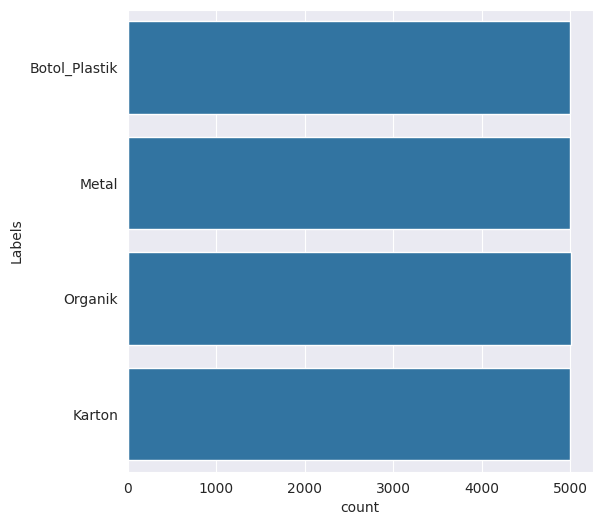

In [ ]:
trash_cat="/content/Trash1/dataset"
file_name=[]
labels=[]
full_path=[]
for path ,subdirs, files in os.walk(trash_cat):
  for name in files:
    full_path.append(os.path.join(path, name))
    labels.append(path.split('/') [-1])
    file_name.append(name)

distribution_data=pd.DataFrame({"path":full_path, 'file_name':file_name, 'Labels':labels})

Label=distribution_data['Labels']
plt.figure(figsize=(6,6))
sns.set_style('darkgrid')
plt.data=sns.countplot(Label)

In [ ]:
my_path="/content/Trash1/dataset"

file_name=[]
labels=[]
full_path=[]

for path, subdirs, files in os.walk(my_path):
  for name in files:
    full_path.append(os.path.join(path, name))
    labels.append(path.split('/')[-1])
    file_name.append(name)

df1=pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
df1.groupby(['labels']).size()

labels
Botol_Plastik    4998
Karton           5000
Metal            5000
Organik          5005
dtype: int64

In [ ]:
X=df1['path']
y=df1['labels']
X_train, X_test,y_train,y_test= train_test_split(X,y,test_size=0.2, random_state=42)

In [ ]:
df_train=pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_test=pd.DataFrame({'path':X_test, 'labels':y_test,'set':'test'})


In [ ]:
df_all=pd.concat([df_train,df_test],ignore_index=True)
print("============================================\n")
print(df_all.groupby(['set','labels']).size(),'\n')
print("===========================================\n")

print(df_all.sample(5))

datasource_path="/content/Trash1/dataset"
dataset_path="/content/Dataset/Final2"
os.makedirs(dataset_path, exist_ok=True)


set    labels       
test   Botol_Plastik     996
       Karton            999
       Metal            1018
       Organik           988
train  Botol_Plastik    4002
       Karton           4001
       Metal            3982
       Organik          4017
dtype: int64 


                                                    path         labels    set
8644   /content/Trash1/dataset/Metal/augmented_Metal_...          Metal  train
18512   /content/Trash1/dataset/Karton/cardboard_976.jpg         Karton   test
11417  /content/Trash1/dataset/Botol_Plastik/plastic_...  Botol_Plastik  train
1922   /content/Trash1/dataset/Organik/augmented_Orga...        Organik  train
15773  /content/Trash1/dataset/Botol_Plastik/plastic3...  Botol_Plastik  train


In [ ]:
for index, row in tq(df_all.iterrows()):
  file_path=row['path']
  if os.path.exists(file_path) ==False:
    file_path=os.path.join(datasource_path, row['labels'], row['image'],split('.')[0])

  if os.path.exists(os.path.join(dataset_path,row['set'], row['labels'])) ==False:
    os.makedirs(os.path.join(dataset_path, row['set'], row['labels'])) ==True

  destination_file_name=file_path.split('/')[-1]

  file_dest=os.path.join(dataset_path, row['set'], row['labels'], destination_file_name)

  if os.path.exists(file_dest) ==False:
    shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

In [ ]:
TRAIN_DIR="/content/Dataset/Final2/train"
TEST_DIR="/content/Dataset/Final2/test"

train_botp= os.path.join(TRAIN_DIR +'/Botol_Plastik')
train_kar=os.path.join(TRAIN_DIR +'/Karton')
train_met=os.path.join(TRAIN_DIR +'/Metal')
train_org=os.path.join(TRAIN_DIR +'/Organik')

test_botp= os.path.join(TEST_DIR +'/Botol_Plastik')
test_kar=os.path.join(TEST_DIR +'/Karton')
test_met=os.path.join(TEST_DIR +'/Metal')
test_org=os.path.join(TEST_DIR +'/Organik')


In [ ]:
datagen=ImageDataGenerator(rescale=1/225., validation_split=0.2)
test_datagen=ImageDataGenerator(rescale=1. /255)
train_generator=datagen.flow_from_directory(TRAIN_DIR,
                                            batch_size=32,
                                            target_size=(150,150),
                                            class_mode='categorical',
                                            subset='training',
                                            shuffle=True
                                            )
validation_generator=datagen.flow_from_directory(TRAIN_DIR,
                                                 batch_size=32,
                                                 target_size=(150,150),
                                                 class_mode='categorical',
                                                 subset='validation',
                                                 shuffle=False)

testing_generator=test_datagen.flow_from_directory(TEST_DIR,
                                                   batch_size=1,
                                                   target_size=(150,150),
                                                   class_mode='categorical',
                                                   shuffle=False)

Found 12802 images belonging to 4 classes.
Found 3199 images belonging to 4 classes.
Found 4001 images belonging to 4 classes.


## Melakukan training tahap 2

### Arsitektur model 2

In [ ]:
model1=Sequential()

model1.add(Conv2D(32,(3,3), padding='same',activation='relu', input_shape=(150,150,3)))
model1.add(Conv2D(32,(3,3),activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPool2D((2,2)))
model1.add(Dropout(0.3))

model1.add(Conv2D(64,(5,5), padding='same',activation='relu'))
model1.add(Conv2D(64,(5,5),activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPool2D((2,2)))
model1.add(Dropout(0.3))

model1.add(Conv2D(128, (7,7), padding='same', activation='relu'))
model1.add(Conv2D(128, (7,7), activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPool2D((2,2)))
model1.add(Dropout(0.3))


model1.add(Conv2D(128, (11,11), padding='same',activation='relu'))
model1.add(Conv2D(128, (11,11),activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPool2D((2,2)))
model1.add(Dropout(0.3))

model1.add(Flatten())

model1.add(Dense(256,activation='relu'))
model1.add(Dropout(0.5))

model1.add(Dense(128,activation='relu'))
model1.add(Dropout(0.3))

model1.add(Dense(4,activation='softmax'))

model1.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 148, 148, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 74, 74, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 70, 70, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 70, 70, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 35, 35, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 35, 35, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 35, 35, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 29, 29, 128)    │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 29, 29, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 14, 14, 128)    │     1,982,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 4, 4, 128)      │     1,982,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             

 Total params: 5,499,684 (20.98 MB)

 Trainable params: 5,498,980 (20.98 MB)

 Non-trainable params: 704 (2.75 KB)

In [ ]:
class_names = [
    'Botol_Plastik', 'Karton',
    'Metal', 'Organik'
]

# Hitung jumlah gambar untuk tiap kelas
class_counts = {}
for class_name in class_names:
    class_path = os.path.join(TRAIN_DIR, class_name)
    class_counts[class_name] = len(os.listdir(class_path))

# Total semua gambar
total_images = sum(class_counts.values())

# Hitung class weights
class_weights = {}
for idx, class_name in enumerate(class_names):
    count = class_counts[class_name]
    class_weights[idx] = (1 / count) * (total_images / len(class_names))



In [ ]:
class CustomCallback(Callback):
  def on_epoch_end(self, epoch,logs=None):
    logs=logs or {}
    val_acc=logs.get('val_accuracy')
    val_loss=logs.get('val_loss')

    if val_acc is not None and val_loss is not None:
      if val_acc >=0.85 and val_loss <=0.55:
        print(f"\nTraining Model Stopped: val_accuracy={val_acc:.2f}, val loss:{val_loss:.2f}")
        self.model.stop_training=True

In [ ]:
model1.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='categorical_crossentropy',metrics =['accuracy'])

### Melakukan training tahap 2

In [ ]:
history=model1.fit(
    train_generator,
    epochs=50,
    batch_size=32,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[CustomCallback()]
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


401/401 ━━━━━━━━━━━━━━━━━━━━ 65s 140ms/step - accuracy: 0.3470 - loss: 1.5462 - val_accuracy: 0.2504 - val_loss: 1.3778
Epoch 2/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 43s 108ms/step - accuracy: 0.4631 - loss: 1.2135 - val_accuracy: 0.3307 - val_loss: 1.3907
Epoch 3/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 43s 107ms/step - accuracy: 0.5244 - loss: 1.1314 - val_accuracy: 0.3686 - val_loss: 1.5444
Epoch 4/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 43s 107ms/step - accuracy: 0.5793 - loss: 1.0381 - val_accuracy: 0.4379 - val_loss: 1.2802
Epoch 5/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 43s 107ms/step - accuracy: 0.6222 - loss: 0.9707 - val_accuracy: 0.4458 - val_loss: 1.2774
Epoch 6/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 43s 107ms/step - accuracy: 0.6528 - loss: 0.9108 - val_accuracy: 0.5714 - val_loss: 1.1363
Epoch 7/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 43s 108ms/step - accuracy: 0.6581 - loss: 0.9087 - val_accuracy: 0.4379 - val_loss: 2.1176
Epoch 8/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 43s 107ms/step - accuracy: 0.6708 - loss: 0.8717 - val

### Melakukan pengujian data training

In [ ]:
loss, accuracy=model.evaluate(train_generator)
print(f"Loss:{loss:.4f}")
print(f"Akurasi:{accuracy:.4f}")

401/401 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - accuracy: 0.5447 - loss: 2.5813
Loss:2.5758
Akurasi:0.5430


### Melakukan pengujian pada data testing

In [ ]:
loss, accuracy=model.evaluate(testing_generator)
print(f"Loss:{loss:.4f}")
print(f"Akurasi:{accuracy:.4f}")

4001/4001 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.6272 - loss: 2.2213
Loss:2.7985
Akurasi:0.5499


### Confusion Matrix tahap 2

4001/4001 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step


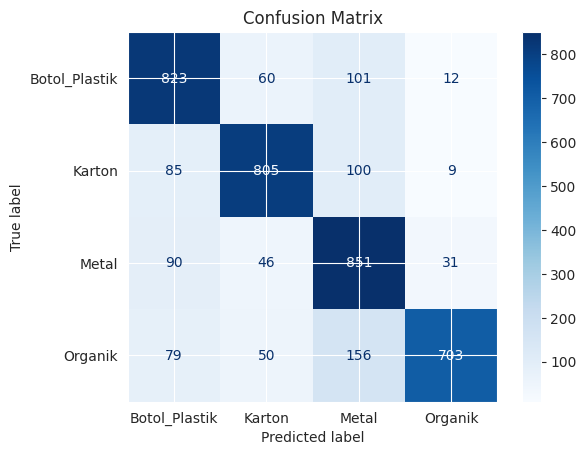

Classification Report 
                precision    recall  f1-score   support

Botol_Plastik       0.76      0.83      0.79       996
       Karton       0.84      0.81      0.82       999
        Metal       0.70      0.84      0.76      1018
      Organik       0.93      0.71      0.81       988

     accuracy                           0.80      4001
    macro avg       0.81      0.79      0.80      4001
 weighted avg       0.81      0.80      0.80      4001



In [ ]:
Y_pred=model1.predict(testing_generator)

y_pred=np.argmax(Y_pred, axis=1)
y_true=testing_generator.classes
class_names=list(testing_generator.class_indices.keys())

Confusion=confusion_matrix(y_true, y_pred)
display=ConfusionMatrixDisplay(confusion_matrix=Confusion, display_labels=class_names)
display.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

report=classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report \n", report )

### Grafik akurasi dan loss

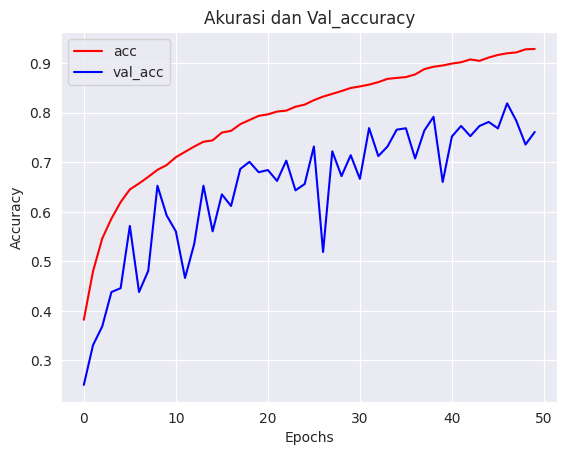

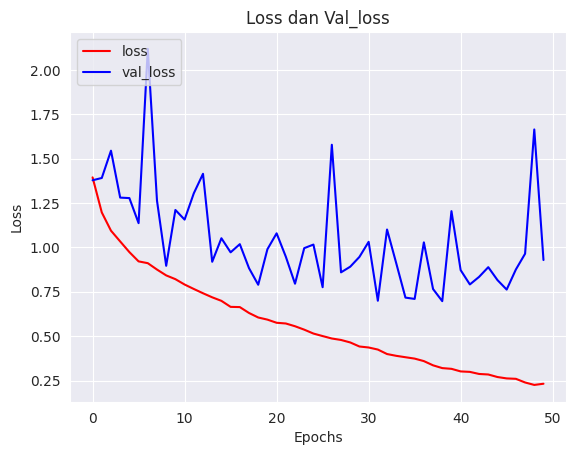

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc,'b')
plt.title('Akurasi dan Val_accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['acc', 'val_acc'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Loss dan Val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

## Menyimpan dan melakukan konvert model

In [ ]:
model.save('ModelPrediksi.h5')

In [ ]:
model.export('saved_model/my_model')

Saved artifact at 'saved_model/my_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  138206576692688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138206576690768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138206576690192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138206576692880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138206576690000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138206576690384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138206576693072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138206576785168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138206572213840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138206572215376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1382065722

In [ ]:
saved_model_dir='/content/saved_model/my_model'

converter=tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model=converter.convert()

with open('model.tflite','wb') as f:
  f.write(tflite_model)

### Melakukan Pengujian model

Saving kaleng.jpg to kaleng.jpg
Prediksi pada gambar kaleng.jpg
Prediksi: Metal


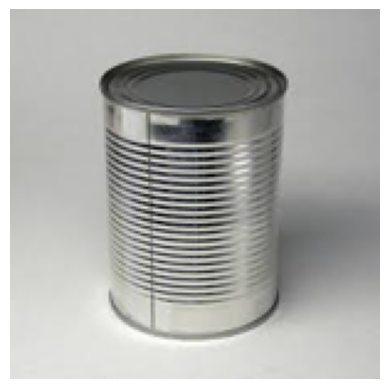

In [ ]:
from google.colab import files
import io
def load_labels(label_file):
  with open(label_file,'r') as f:
    return [line.strip() for line in f.readlines()]

def load_image(image_bytes, input_size=(150,150)):
  img=Image.open(io.BytesIO(image_bytes))
  img=img.resize(input_size)
  img=np.array(img, dtype=np.float32)

  img=np.expand_dims(img, axis=0)
  img= img/255

  return img, img[0]

interpreter=tf.lite.Interpreter(model_path="/content/model.tflite")
interpreter.allocate_tensors()

labels=load_labels('/content/label.txt')

input_details= interpreter.get_input_details()
output_details= interpreter.get_output_details()

def predict_image(image_bytes):
  image,original_image=load_image(image_bytes)

  input_index=input_details[0]['index']
  output_index=output_details[0]['index']

  interpreter.set_tensor(input_index, image)

  interpreter.invoke()
  output=interpreter.get_tensor(output_index)

  predicted_class=np.argmax(output)
  print(f"Prediksi: {labels[predicted_class]}")

  plt.imshow(original_image)
  plt.axis('off')
  plt.show()

uploaded=files.upload()

for filename in uploaded.keys():
  print(f"Prediksi pada gambar {filename}")
  with open (filename, 'rb') as f:
    image_bytes=f.read()
    predict_image(image_bytes)

Saving orgnik.jpg to orgnik.jpg
Prediksi pada gambar orgnik.jpg
Prediksi: Organik


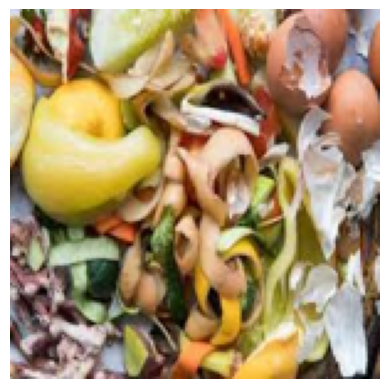

In [ ]:
def load_labels(label_file):
  with open(label_file,'r') as f:
    return [line.strip() for line in f.readlines()]

def load_image(image_bytes, input_size=(150,150)):
  img=Image.open(io.BytesIO(image_bytes))
  img=img.resize(input_size)
  img=np.array(img, dtype=np.float32)

  img=np.expand_dims(img, axis=0)
  img= img/255

  return img, img[0]

interpreter=tf.lite.Interpreter(model_path="/content/model.tflite")
interpreter.allocate_tensors()

labels=load_labels('/content/label.txt')

input_details= interpreter.get_input_details()
output_details= interpreter.get_output_details()

def predict_image(image_bytes):
  image,original_image=load_image(image_bytes)

  input_index=input_details[0]['index']
  output_index=output_details[0]['index']

  interpreter.set_tensor(input_index, image)

  interpreter.invoke()
  output=interpreter.get_tensor(output_index)

  predicted_class=np.argmax(output)
  print(f"Prediksi: {labels[predicted_class]}")

  plt.imshow(original_image)
  plt.axis('off')
  plt.show()

uploaded=files.upload()

for filename in uploaded.keys():
  print(f"Prediksi pada gambar {filename}")
  with open (filename, 'rb') as f:
    image_bytes=f.read()
    predict_image(image_bytes)

Saving Botol.jpg to Botol.jpg
Prediksi pada gambar Botol.jpg
Prediksi: Botol_Plastik


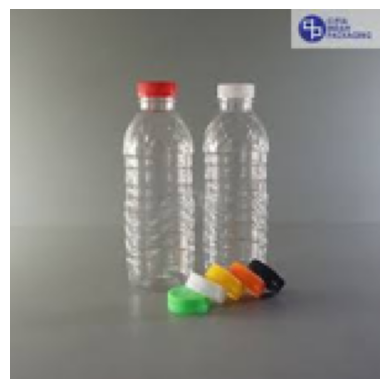

In [ ]:
def load_labels(label_file):
  with open(label_file,'r') as f:
    return [line.strip() for line in f.readlines()]

def load_image(image_bytes, input_size=(150,150)):
  img=Image.open(io.BytesIO(image_bytes))
  img=img.resize(input_size)
  img=np.array(img, dtype=np.float32)

  img=np.expand_dims(img, axis=0)
  img= img/255

  return img, img[0]

interpreter=tf.lite.Interpreter(model_path="/content/model.tflite")
interpreter.allocate_tensors()

labels=load_labels('/content/label.txt')

input_details= interpreter.get_input_details()
output_details= interpreter.get_output_details()

def predict_image(image_bytes):
  image,original_image=load_image(image_bytes)

  input_index=input_details[0]['index']
  output_index=output_details[0]['index']

  interpreter.set_tensor(input_index, image)

  interpreter.invoke()
  output=interpreter.get_tensor(output_index)

  predicted_class=np.argmax(output)
  print(f"Prediksi: {labels[predicted_class]}")

  plt.imshow(original_image)
  plt.axis('off')
  plt.show()

uploaded=files.upload()

for filename in uploaded.keys():
  print(f"Prediksi pada gambar {filename}")
  with open (filename, 'rb') as f:
    image_bytes=f.read()
    predict_image(image_bytes)

Saving Kardus.jpg to Kardus.jpg
Prediksi pada gambar Kardus.jpg
Prediksi: Karton


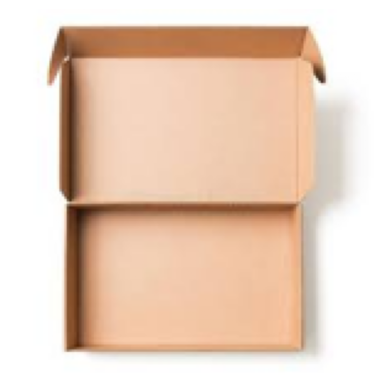

In [ ]:
def load_labels(label_file):
  with open(label_file,'r') as f:
    return [line.strip() for line in f.readlines()]

def load_image(image_bytes, input_size=(150,150)):
  img=Image.open(io.BytesIO(image_bytes))
  img=img.resize(input_size)
  img=np.array(img, dtype=np.float32)

  img=np.expand_dims(img, axis=0)
  img= img/255

  return img, img[0]

interpreter=tf.lite.Interpreter(model_path="/content/model.tflite")
interpreter.allocate_tensors()

labels=load_labels('/content/label.txt')

input_details= interpreter.get_input_details()
output_details= interpreter.get_output_details()

def predict_image(image_bytes):
  image,original_image=load_image(image_bytes)

  input_index=input_details[0]['index']
  output_index=output_details[0]['index']

  interpreter.set_tensor(input_index, image)

  interpreter.invoke()
  output=interpreter.get_tensor(output_index)

  predicted_class=np.argmax(output)
  print(f"Prediksi: {labels[predicted_class]}")

  plt.imshow(original_image)
  plt.axis('off')
  plt.show()

uploaded=files.upload()

for filename in uploaded.keys():
  print(f"Prediksi pada gambar {filename}")
  with open (filename, 'rb') as f:
    image_bytes=f.read()
    predict_image(image_bytes)